In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter


from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
gbin1 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin1_all.npz')
pbin1 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin1_all.npz')

gbin2 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin2_all.npz')
pbin2 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin2_all.npz')

gbin3 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin3_all.npz')
pbin3 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin3_all.npz')

gbin4 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin4_all.npz')
pbin4 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin4_all.npz')

gbin5 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin5_all.npz')
pbin5 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin5_all.npz')

gbin6 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin6_all.npz')
pbin6 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin6_all.npz')

In [3]:
Ebins = 5
gim = gbin5['image'][:]
pim = pbin5['image'][:]
#gim = torch.tensor(gim).float() 
#pim = torch.tensor(gim).float() 
gim_label = torch.zeros([len(gim)])
pim_label = torch.ones([len(pim)]) 
classes = {0:'gamma',1:'proton'}

In [4]:
train_images = np.vstack((gim[:int(len(gim)*0.5)],pim[:int(len(pim)*0.5)]))
test_images  = np.vstack((gim[int(len(gim)*0.5):int(len(gim)*0.75)],pim[int(len(pim)*0.5):int(len(pim)*0.75)]))
val_images  = np.vstack((gim[int(len(gim)*0.75):],pim[int(len(pim)*0.75):]))
train_labels = np.hstack((gim_label[:int(len(gim)*0.5)],pim_label[:int(len(pim)*0.5)]))
test_labels  = np.hstack((gim_label[int(len(gim)*0.5):int(len(gim)*0.75)],pim_label[int(len(pim)*0.5):int(len(pim)*0.75)]))
val_labels  = np.hstack((gim_label[int(len(gim)*0.75):],pim_label[int(len(pim)*0.75):]))

In [5]:
train_images = torch.tensor(train_images).float()
train_labels = torch.tensor(train_labels).float()
test_images  = torch.tensor(test_images).float()
test_labels  = torch.tensor(test_labels).float()
val_images  = torch.tensor(val_images).float()
val_labels  = torch.tensor(val_labels).float()

In [6]:
train_sets = ([(train_images[i],train_labels[i])for i in range(len(train_labels))])
test_sets = ([(test_images[i],test_labels[i])for i in range(len(test_labels))])
val_sets = ([(val_images[i],val_labels[i])for i in range(len(val_labels))])

In [7]:
trainloader = torch.utils.data.DataLoader(train_sets, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_sets, batch_size=4, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_sets, batch_size=4, shuffle=True, num_workers=2)

In [8]:
print('# of gamma images : {}, # of proton images : {}'.format(len(gim),len(pim)))
print('# of Train : {}, # of Test : {}, # of Validation : {}'.format(len(train_sets),len(test_sets),len(val_sets)))

# of gamma images : 1288, # of proton images : 570
# of Train : 929, # of Test : 464, # of Validation : 465


In [9]:
dataloader = {'train':trainloader, 'valid':valloader}

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7)
        self.batch1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)    
        #self.batch2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_drop = nn.Dropout2d()
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*6*6, 500)
        self.fc2 = nn.Linear(500, 128)
        self.fc3 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch1(x)
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.batch2(x)
        x = x.view(-1, 64*6*6)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,training=self.training)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [11]:
net = Net()
net = net.cuda()

In [12]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
def train_model(model, dataloader, criterion, optimizer, scheduler, Ebins, num_epochs=1):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train':[],'valid':[]}
    accuracy = {'train':[],'valid':[]}
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-'*10)
        for phase in ['train','valid']:
            if phase=='train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects= 0
            ep_running_loss = 0.0
            ep_running_corrects = 0
            
            for i, data in enumerate(dataloader[phase]):
                inputs, labels = data
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
                #inputs = Variable(inputs)
                #labels = Variable(labels)
                if phase=='train':
                    optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels.long())
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data
                ep_running_loss += loss.data
                running_corrects += torch.sum(preds==labels.long())
                ep_running_corrects += torch.sum(preds==labels.long())
                if i%100==99:
                    writer.add_scalar('{} loss'.format(phase),
                                     running_loss/100,
                                     epoch*len(dataloader[phase])+i)
                    writer.add_scalar('{} Accuracy'.format(phase),
                                     float(running_corrects)/(100.0*4.0),
                                     epoch*len(dataloader[phase])+i)
                    writer.add_figure('predictions vs actuals, {}'.format(phase),
                                     plot_classes_preds(model, inputs, labels),
                                     global_step=epoch*len(dataloader[phase])+i)
                    running_loss = 0.0
                    running_corrects = 0

            writer.close()
            epoch_loss = ep_running_loss/(len(dataloader[phase])*4)
            epoch_acc = float(ep_running_corrects)/(len(dataloader[phase])*4)
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)
            print('{} Loss: {:.4f}, Acc : {:.4f}'.format( phase, epoch_loss, epoch_acc))    
            if phase=='valid' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    print()
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best Acc: {:4f}".format(best_acc))
    model.load_state_dict(best_model_wts)
    return model,losses,accuracy    

In [14]:
def plottingLossAcc(losses,accuracy,datatype,Eb):
  # plotting losses, and accuracy
    plt.plot(range(1,len(losses)+1),losses, 'r',label='loss')
    plt.title('{} Losses B={}'.format(datatype.capitalize(), Eb))
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend()
    plt.savefig("plots/300_50000_m2.7/4filter/{}_loss_B{}.png".format(datatype, Eb))
    plt.show()

    plt.plot(range(1,len(accuracy)+1), accuracy, 'r', label='accuracy')
    plt.title('{} Accuracy B={}'.format(datatype.capitalize(),Eb))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig("plots/300_50000_m2.7/4filter/{}_accuracy_B{}.png".format(datatype, Eb))
    plt.show()

In [15]:
def test(testloader):
    correct = 0
    total = 0
    y_score = np.array([])
    y = np.array([])
    test_losses = []
    for data in testloader:
        images, labels = data
        labels = labels.cuda()
        outputs = net(Variable(images.cuda()))
        #outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels.long().cuda())
        #loss = criterion(outputs, labels.long())
        y_score = np.append(y_score,outputs.data.cpu().detach().numpy())
        y = np.append(y,labels.cpu().numpy())
        test_losses.append(loss.data/16.0)
        total += labels.size(0)
        correct += (predicted == labels.long().cuda()).sum()
        #correct += (predicted == labels.long()).sum()
    return y, y_score, correct, total,  test_losses

In [16]:
def roc(y,y_score,correct,total,Eb):
    ny = []
    for i in y:
        if i == 0: ny.append([1,0])
        else : ny.append([0,1])

    fpr,tpr, _  = roc_curve(np.array(ny).ravel(),y_score.ravel())
    roc_auc = auc(fpr,tpr)
    fig, ax = plt.subplots()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set(xlim=[0.0, 1.0], ylim=[0.0,1.0],title='ROC curve B={}'.format(Eb))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    fig.savefig("plots/300_50000_m2.7/4filter/roc_B{}.png".format(Eb))
    plt.show()
    print('Accuracy of the network on the {} test images: {} %'.format(len(testloader),100 * correct / total))


In [17]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [18]:
def images_to_probs(net, images):
    output = net(images)
    _, preds_tensor= torch.max(output,1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [19]:
def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1,4,idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
        classes[preds[idx]],
               probs[idx]*100.0,
               classes[int(labels[idx])]),
                    color=('green' if preds[idx]==labels[idx].long() else "red"))
    return fig

In [20]:
'''
writer = SummaryWriter('runs/bin1')
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0])
matplotlib_imshow(img_grid)
writer.add_image('test_images', img_grid)

writer.add_graph(net, images)

writer.close()
'''

"\nwriter = SummaryWriter('runs/bin1')\ndataiter = iter(trainloader)\nimages, labels = dataiter.next()\nimg_grid = torchvision.utils.make_grid(images[0])\nmatplotlib_imshow(img_grid)\nwriter.add_image('test_images', img_grid)\n\nwriter.add_graph(net, images)\n\nwriter.close()\n"

In [21]:
from datetime import datetime
now = datetime.now()
logdir = "runs/bin{}/".format(Ebins) + now.strftime("%Y%m%d-%H%M%S") + "/"
writer = SummaryWriter(logdir)
net,losses,accuracy = train_model(net, dataloader, criterion, optimizer, exp_lr_scheduler, Ebins,10)

Epoch 0/9
----------


/usr/local/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1415, Acc : 0.7135
valid Loss: 0.1584, Acc : 0.6859
Epoch 1/9
----------
train Loss: 0.1121, Acc : 0.7843
valid Loss: 0.1609, Acc : 0.6859
Epoch 2/9
----------
train Loss: 0.0962, Acc : 0.8197
valid Loss: 0.1700, Acc : 0.6923
Epoch 3/9
----------
train Loss: 0.0900, Acc : 0.8455
valid Loss: 0.1749, Acc : 0.3056
Epoch 4/9
----------
train Loss: 0.0793, Acc : 0.8734
valid Loss: 0.1765, Acc : 0.3056
Epoch 5/9
----------
train Loss: 0.0686, Acc : 0.8927
valid Loss: 0.1421, Acc : 0.8526
Epoch 6/9
----------
train Loss: 0.0485, Acc : 0.9249
valid Loss: 0.1821, Acc : 0.3056
Epoch 7/9
----------
train Loss: 0.0478, Acc : 0.9335
valid Loss: 0.1808, Acc : 0.3056
Epoch 8/9
----------
train Loss: 0.0443, Acc : 0.9324
valid Loss: 0.1815, Acc : 0.3056
Epoch 9/9
----------
train Loss: 0.0428, Acc : 0.9431
valid Loss: 0.1799, Acc : 0.3056

Training complete in 1s
Best Acc: 0.852564


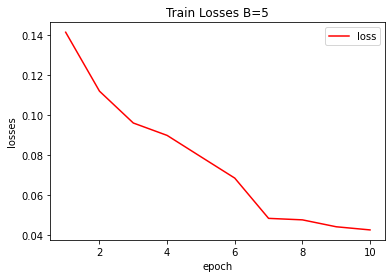

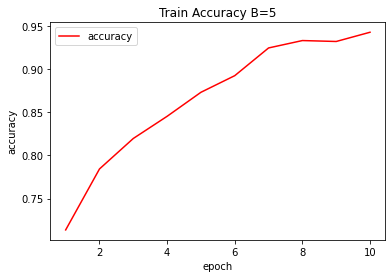

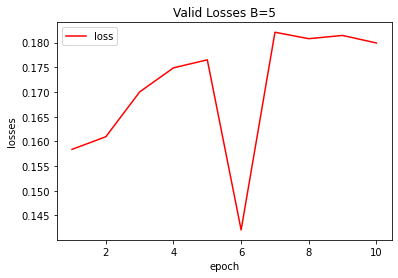

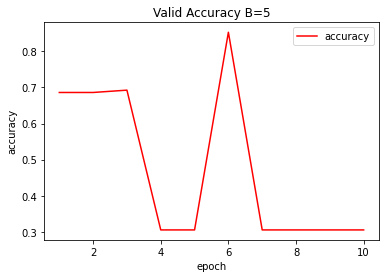

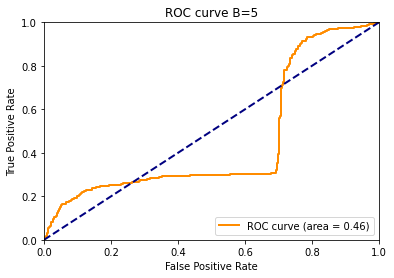

Accuracy of the network on the 116 test images: 30 %


In [22]:
plottingLossAcc(losses['train'],accuracy['train'],datatype='train', Eb=Ebins)
plottingLossAcc(losses['valid'],accuracy['valid'],datatype='valid', Eb=Ebins)
y,y_score,correct,total,test_losses = test(testloader)

roc(y,y_score,correct,total,Ebins)